In [1]:
#import dependencies
import nltk
import pandas as pd 
from nltk.corpus import wordnet
from nltk.corpus import stopwords 
import json
from nltk import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multiclass import OneVsRestClassifier

In [2]:
#making txt file into dataframe 
df = pd.read_csv('booksummaries.txt', sep='\t',
                 names=['id1', 'id2', 'title', 'author', 'year', 'genres', 'summary'],
                 usecols=[2, 3, 5, 6], converters={'genres' : lambda s : (list(json.loads(s).values()) if s else None)})

In [3]:
df

,title,author,genres,summary
0,Animal Farm,George Orwell,"[Roman à clef, Satire, Children's literature, ...","Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,Anthony Burgess,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan..."
2,The Plague,Albert Camus,"[Existentialism, Fiction, Absurdist fiction, N...",The text of The Plague is divided into five p...
3,An Enquiry Concerning Human Understanding,David Hume,None,The argument of the Enquiry proceeds by a ser...
4,A Fire Upon the Deep,Vernor Vinge,"[Hard science fiction, Science Fiction, Specul...",The novel posits that space around the Milky ...
...,...,...,...,...
16554,Under Wildwood,Colin Meloy,None,"Prue McKeel, having rescued her brother from ..."
16555,Transfer of Power,Vince Flynn,"[Thriller, Fiction]",The reader first meets Rapp while he is doing...
16556,Decoded,Jay-Z,[Autobiography],The book follows very rough chronological ord...
16557,America Again: Re-becoming The Greatness We Ne...,Stephen Colbert,None,Colbert addresses topics including Wall Stree...


In [4]:

def tokenize_summary(df, summary):
    # Removing punctuation
    tokenizer = RegexpTokenizer(r"\w+")
    stop_words = set(stopwords.words("english"))  
    
    # Tokenize and preprocess text
    tokens = df[summary].map(lambda x: tokenizer.tokenize(x.lower())) 
    tokens = tokens.map(lambda x: [i.strip("_") for i in x])  
    tokens = tokens.map(lambda x: [i for i in x if i not in stop_words]) 
    tokens = tokens.map(lambda x: [i for i in x if i != ""])  
    
    return tokens

In [5]:
df["Tokenized_Summary"] = tokenize_summary(df, "summary")

In [6]:
df

,title,author,genres,summary,Tokenized_Summary
0,Animal Farm,George Orwell,"[Roman à clef, Satire, Children's literature, ...","Old Major, the old boar on the Manor Farm, ca...","[old, major, old, boar, manor, farm, calls, an..."
1,A Clockwork Orange,Anthony Burgess,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan...","[alex, teenager, living, near, future, england..."
2,The Plague,Albert Camus,"[Existentialism, Fiction, Absurdist fiction, N...",The text of The Plague is divided into five p...,"[text, plague, divided, five, parts, town, ora..."
3,An Enquiry Concerning Human Understanding,David Hume,None,The argument of the Enquiry proceeds by a ser...,"[argument, enquiry, proceeds, series, incremen..."
4,A Fire Upon the Deep,Vernor Vinge,"[Hard science fiction, Science Fiction, Specul...",The novel posits that space around the Milky ...,"[novel, posits, space, around, milky, way, div..."
...,...,...,...,...,...
16554,Under Wildwood,Colin Meloy,None,"Prue McKeel, having rescued her brother from ...","[prue, mckeel, rescued, brother, dowager, gove..."
16555,Transfer of Power,Vince Flynn,"[Thriller, Fiction]",The reader first meets Rapp while he is doing...,"[reader, first, meets, rapp, covert, operation..."
16556,Decoded,Jay-Z,[Autobiography],The book follows very rough chronological ord...,"[book, follows, rough, chronological, order, s..."
16557,America Again: Re-becoming The Greatness We Ne...,Stephen Colbert,None,Colbert addresses topics including Wall Stree...,"[colbert, addresses, topics, including, wall, ..."


In [7]:
all_genres = []

In [8]:
genres_column = df['genres']

In [9]:
genres_column.dropna()

0        [Roman à clef, Satire, Children's literature, ...
1        [Science Fiction, Novella, Speculative fiction...
2        [Existentialism, Fiction, Absurdist fiction, N...
4        [Hard science fiction, Science Fiction, Specul...
5                                [War novel, Roman à clef]
                               ...                        
16549                                    [Science Fiction]
16551                        [Thriller, Fiction, Suspense]
16555                                  [Thriller, Fiction]
16556                                      [Autobiography]
16558              [Epistolary novel, Speculative fiction]
Name: genres, Length: 12841, dtype: object

In [10]:

# Iterate through each row to extract and split the list of genres
all_genres = []
# Iterate through each element in the 'genres_column'
for genres_item in genres_column:
    # Check if the element is a string
    if isinstance(genres_item, str):
        # Split the string by comma and extend the list of all genres
        all_genres.extend([genre.strip() for genre in genres_item.split(',')])
    # Check if the element is a list
    elif isinstance(genres_item, list):
        # Extend the list of all genres directly
        all_genres.extend(genres_item)

# Count the occurrences of each unique genre
genre_counts = Counter(all_genres)

In [11]:
# Iterate through each row to extract and split the list of genres
book_list = []
# Iterate through each element in the 'genres_column'
valid_genres = [#'Speculative fiction',
                'Science Fiction','Non-fiction','Children\'s literature',
                'Fantasy', 'Mystery', 'Suspense', 'Young adult literature']
for i, row in df.iterrows():
    if row["genres"]:
        for genre in valid_genres:
            new_row={
                "title": row["title"],
                "author": row["author"],
                "summary": row["summary"]
                }
            genre_list=row["genres"]
            if genre in genre_list:
                new_row["genre"]=genre
                book_list.append(new_row)
book_df = pd.DataFrame(book_list)
book_df
#     # Check if the element is a string
#     if isinstance(genres_item, str):
#         # Split the string by comma and extend the list of all genres
#         all_genres.extend([genre.strip() for genre in genres_item.split(',')])
#     # Check if the element is a list
#     elif isinstance(genres_item, list):
#         # Extend the list of all genres directly
#         all_genres.extend(genres_item)

,title,author,summary,genre
0,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca...",Children's literature
1,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan...",Science Fiction
2,A Fire Upon the Deep,Vernor Vinge,The novel posits that space around the Milky ...,Science Fiction
3,A Fire Upon the Deep,Vernor Vinge,The novel posits that space around the Milky ...,Fantasy
4,A Wizard of Earthsea,Ursula K. Le Guin,"Ged is a young boy on Gont, one of the larger...",Children's literature
...,...,...,...,...
10616,Heaven,V. C. Andrews,Heaven Leigh Casteel is a fourteen year old g...,Young adult literature
10617,Dark Angel,V. C. Andrews,After the events of Heaven (the first book in...,Young adult literature
10618,Gates of Paradise,V. C. Andrews,"A novel about Annie Stonewall, the daughter o...",Young adult literature
10619,The Third Lynx,Timothy Zahn,The story starts with former government agent...,Science Fiction


In [12]:
book_df["Tokenized_Summary"] = tokenize_summary(book_df, "summary")

In [13]:
book_df

,title,author,summary,genre,Tokenized_Summary
0,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca...",Children's literature,"[old, major, old, boar, manor, farm, calls, an..."
1,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan...",Science Fiction,"[alex, teenager, living, near, future, england..."
2,A Fire Upon the Deep,Vernor Vinge,The novel posits that space around the Milky ...,Science Fiction,"[novel, posits, space, around, milky, way, div..."
3,A Fire Upon the Deep,Vernor Vinge,The novel posits that space around the Milky ...,Fantasy,"[novel, posits, space, around, milky, way, div..."
4,A Wizard of Earthsea,Ursula K. Le Guin,"Ged is a young boy on Gont, one of the larger...",Children's literature,"[ged, young, boy, gont, one, larger, islands, ..."
...,...,...,...,...,...
10616,Heaven,V. C. Andrews,Heaven Leigh Casteel is a fourteen year old g...,Young adult literature,"[heaven, leigh, casteel, fourteen, year, old, ..."
10617,Dark Angel,V. C. Andrews,After the events of Heaven (the first book in...,Young adult literature,"[events, heaven, first, book, casteel, series,..."
10618,Gates of Paradise,V. C. Andrews,"A novel about Annie Stonewall, the daughter o...",Young adult literature,"[novel, annie, stonewall, daughter, heaven, ca..."
10619,The Third Lynx,Timothy Zahn,The story starts with former government agent...,Science Fiction,"[story, starts, former, government, agent, fra..."


In [14]:
book_df.dropna(inplace=True)

In [15]:
book_df

,title,author,summary,genre,Tokenized_Summary
0,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca...",Children's literature,"[old, major, old, boar, manor, farm, calls, an..."
1,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan...",Science Fiction,"[alex, teenager, living, near, future, england..."
2,A Fire Upon the Deep,Vernor Vinge,The novel posits that space around the Milky ...,Science Fiction,"[novel, posits, space, around, milky, way, div..."
3,A Fire Upon the Deep,Vernor Vinge,The novel posits that space around the Milky ...,Fantasy,"[novel, posits, space, around, milky, way, div..."
4,A Wizard of Earthsea,Ursula K. Le Guin,"Ged is a young boy on Gont, one of the larger...",Children's literature,"[ged, young, boy, gont, one, larger, islands, ..."
...,...,...,...,...,...
10616,Heaven,V. C. Andrews,Heaven Leigh Casteel is a fourteen year old g...,Young adult literature,"[heaven, leigh, casteel, fourteen, year, old, ..."
10617,Dark Angel,V. C. Andrews,After the events of Heaven (the first book in...,Young adult literature,"[events, heaven, first, book, casteel, series,..."
10618,Gates of Paradise,V. C. Andrews,"A novel about Annie Stonewall, the daughter o...",Young adult literature,"[novel, annie, stonewall, daughter, heaven, ca..."
10619,The Third Lynx,Timothy Zahn,The story starts with former government agent...,Science Fiction,"[story, starts, former, government, agent, fra..."


In [16]:
# Preparing data
book_df["Tokenized_Summary"] = book_df["Tokenized_Summary"].apply(lambda x: x if isinstance(x, list) else [])
X = book_df["Tokenized_Summary"].apply(lambda x: " ".join(x))
y = book_df["genre"]

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

# Extracting features
vectorizer = TfidfVectorizer(max_features=100)  
# selecting svc model
model = Pipeline([
    ("vectorizer", vectorizer),
    ("classifier", LinearSVC())
])

# training the model
model.fit(X_train, y_train)

# evaluating the model
y_pred = model.predict(X_test)

# calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# printing classification report
print(classification_report(y_test, y_pred))



C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.4391089108910891
                        precision    recall  f1-score   support

 Children's literature       0.42      0.51      0.46       430
               Fantasy       0.42      0.47      0.44       453
               Mystery       0.39      0.43      0.41       275
           Non-fiction       0.47      0.36      0.41        42
       Science Fiction       0.50      0.60      0.55       540
              Suspense       0.00      0.00      0.00       142
Young adult literature       0.14      0.01      0.01       138

              accuracy                           0.44      2020
             macro avg       0.33      0.34      0.32      2020
          weighted avg       0.39      0.44      0.41      2020



In [17]:

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)

C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training Accuracy: 0.45158494304110947
Testing Accuracy: 0.4391089108910891


In [18]:
#attempt 2 (raising max features to 2000 and lowering random state to 1 )
# Preparing data
book_df["Tokenized_Summary"] = book_df["Tokenized_Summary"].apply(lambda x: x if isinstance(x, list) else [])
X = book_df["Tokenized_Summary"].apply(lambda x: " ".join(x))
y = book_df["genre"]

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Extracting features
vectorizer = TfidfVectorizer(max_features=2000)  

# selecting svc model
model = Pipeline([
    ("vectorizer", vectorizer),
    ("classifier", LinearSVC())
])

# training the model
model.fit(X_train, y_train)

# evaluating the model
y_pred = model.predict(X_test)

# calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# printing classification report
print(classification_report(y_test, y_pred))


C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.4297029702970297
                        precision    recall  f1-score   support

 Children's literature       0.44      0.42      0.43       209
               Fantasy       0.42      0.49      0.45       208
               Mystery       0.31      0.34      0.33       148
           Non-fiction       0.56      0.31      0.40        16
       Science Fiction       0.63      0.62      0.62       276
              Suspense       0.03      0.03      0.03        80
Young adult literature       0.28      0.22      0.24        73

              accuracy                           0.43      1010
             macro avg       0.38      0.35      0.36      1010
          weighted avg       0.43      0.43      0.43      1010



In [19]:


# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)

C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training Accuracy: 0.6986572749284614
Testing Accuracy: 0.4297029702970297


In [20]:
#attempt 3 (raising max features to 2000 and rasing random state to 5 )
# Preparing data
book_df["Tokenized_Summary"] = book_df["Tokenized_Summary"].apply(lambda x: x if isinstance(x, list) else [])
X = book_df["Tokenized_Summary"].apply(lambda x: " ".join(x))
y = book_df["genre"]

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=5)

# Extracting features
vectorizer = TfidfVectorizer(max_features=2000)  

# selecting svc model
model = Pipeline([
    ("vectorizer", vectorizer),
    ("classifier", LinearSVC())
])

# training the model
model.fit(X_train, y_train)

# evaluating the model
y_pred = model.predict(X_test)

# calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# printing classification report
print(classification_report(y_test, y_pred))

# Evaluate the model
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)

C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.4514851485148515
                        precision    recall  f1-score   support

 Children's literature       0.44      0.38      0.41       226
               Fantasy       0.38      0.50      0.43       202
               Mystery       0.37      0.40      0.38       138
           Non-fiction       1.00      0.86      0.92        14
       Science Fiction       0.68      0.66      0.67       276
              Suspense       0.03      0.03      0.03        77
Young adult literature       0.33      0.25      0.28        77

              accuracy                           0.45      1010
             macro avg       0.46      0.44      0.45      1010
          weighted avg       0.45      0.45      0.45      1010

Training Accuracy: 0.6937046004842615
Testing Accuracy: 0.4514851485148515


In [21]:
#attempt 3 (raising max features to 2000 and rasing random state to 10 )
# Preparing data
book_df["Tokenized_Summary"] = book_df["Tokenized_Summary"].apply(lambda x: x if isinstance(x, list) else [])
X = book_df["Tokenized_Summary"].apply(lambda x: " ".join(x))
y = book_df["genre"]

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

# Extracting features
vectorizer = TfidfVectorizer(max_features=2000)  

# selecting svc model
model = Pipeline([
    ("vectorizer", vectorizer),
    ("classifier", LinearSVC())
])

# training the model
model.fit(X_train, y_train)

# evaluating the model
y_pred = model.predict(X_test)

# calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# printing classification report
print(classification_report(y_test, y_pred))

# Evaluate the model
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)

C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.4396039603960396
                        precision    recall  f1-score   support

 Children's literature       0.41      0.43      0.42       210
               Fantasy       0.44      0.50      0.47       213
               Mystery       0.33      0.34      0.33       141
           Non-fiction       1.00      0.47      0.64        15
       Science Fiction       0.65      0.64      0.65       281
              Suspense       0.03      0.03      0.03        78
Young adult literature       0.21      0.15      0.18        72

              accuracy                           0.44      1010
             macro avg       0.44      0.36      0.39      1010
          weighted avg       0.44      0.44      0.44      1010

Training Accuracy: 0.6963460268545014
Testing Accuracy: 0.4396039603960396


In [22]:
#attempt 4 ( max features to 2000 and rasing random state to 10 )
# Preparing data
book_df["Tokenized_Summary"] = book_df["Tokenized_Summary"].apply(lambda x: x if isinstance(x, list) else [])
X = book_df["Tokenized_Summary"].apply(lambda x: " ".join(x))
y = book_df["genre"]

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

# Extracting features
vectorizer = TfidfVectorizer(max_features=2000)  

# selecting svc model
model = Pipeline([
    ("vectorizer", vectorizer),
    ("classifier", LinearSVC())
])

# training the model
model.fit(X_train, y_train)

# evaluating the model
y_pred = model.predict(X_test)

# calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# printing classification report
print(classification_report(y_test, y_pred))

# Evaluate the model
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)

C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.4396039603960396
                        precision    recall  f1-score   support

 Children's literature       0.41      0.43      0.42       210
               Fantasy       0.44      0.50      0.47       213
               Mystery       0.33      0.34      0.33       141
           Non-fiction       1.00      0.47      0.64        15
       Science Fiction       0.65      0.64      0.65       281
              Suspense       0.03      0.03      0.03        78
Young adult literature       0.21      0.15      0.18        72

              accuracy                           0.44      1010
             macro avg       0.44      0.36      0.39      1010
          weighted avg       0.44      0.44      0.44      1010

Training Accuracy: 0.6963460268545014
Testing Accuracy: 0.4396039603960396


In [23]:
#attempt 5 ( max features to 2000 and rasing random state to 20)
# Preparing data
book_df["Tokenized_Summary"] = book_df["Tokenized_Summary"].apply(lambda x: x if isinstance(x, list) else [])
X = book_df["Tokenized_Summary"].apply(lambda x: " ".join(x))
y = book_df["genre"]

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20)

# Extracting features
vectorizer = TfidfVectorizer(max_features=2000)  

# selecting svc model
model = Pipeline([
    ("vectorizer", vectorizer),
    ("classifier", LinearSVC())
])

# training the model
model.fit(X_train, y_train)

# evaluating the model
y_pred = model.predict(X_test)

# calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# printing classification report
print(classification_report(y_test, y_pred))

# Evaluate the model
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)

C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.4376237623762376
                        precision    recall  f1-score   support

 Children's literature       0.39      0.38      0.38       195
               Fantasy       0.43      0.45      0.44       219
               Mystery       0.38      0.39      0.38       153
           Non-fiction       0.83      0.62      0.71        24
       Science Fiction       0.59      0.71      0.64       256
              Suspense       0.02      0.01      0.01        93
Young adult literature       0.28      0.19      0.22        70

              accuracy                           0.44      1010
             macro avg       0.42      0.39      0.40      1010
          weighted avg       0.42      0.44      0.42      1010

Training Accuracy: 0.6953554919656615
Testing Accuracy: 0.4376237623762376


In [24]:
#attempt 6 ( max features to 2000 and rasing random state to 25 )
# Preparing data
book_df["Tokenized_Summary"] = book_df["Tokenized_Summary"].apply(lambda x: x if isinstance(x, list) else [])
X = book_df["Tokenized_Summary"].apply(lambda x: " ".join(x))
y = book_df["genre"]

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=25)

# Extracting features
vectorizer = TfidfVectorizer(max_features=2000)  

# selecting svc model
model = Pipeline([
    ("vectorizer", vectorizer),
    ("classifier", LinearSVC())
])

# training the model
model.fit(X_train, y_train)

# evaluating the model
y_pred = model.predict(X_test)

# calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# printing classification report
print(classification_report(y_test, y_pred))

# Evaluate the model
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)

C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.4613861386138614
                        precision    recall  f1-score   support

 Children's literature       0.38      0.45      0.41       187
               Fantasy       0.46      0.49      0.47       219
               Mystery       0.36      0.30      0.33       141
           Non-fiction       0.94      0.54      0.68        28
       Science Fiction       0.66      0.67      0.66       296
              Suspense       0.06      0.06      0.06        65
Young adult literature       0.31      0.20      0.24        74

              accuracy                           0.46      1010
             macro avg       0.45      0.39      0.41      1010
          weighted avg       0.47      0.46      0.46      1010

Training Accuracy: 0.6908430552498349
Testing Accuracy: 0.4613861386138614


In [25]:
#attempt 7 ( max features to 2000 and rasing random state to 30 )
# Preparing data
book_df["Tokenized_Summary"] = book_df["Tokenized_Summary"].apply(lambda x: x if isinstance(x, list) else [])
X = book_df["Tokenized_Summary"].apply(lambda x: " ".join(x))
y = book_df["genre"]

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=30)

# Extracting features
vectorizer = TfidfVectorizer(max_features=2000)  

# selecting svc model
model = Pipeline([
    ("vectorizer", vectorizer),
    ("classifier", LinearSVC())
])

# training the model
model.fit(X_train, y_train)

# evaluating the model
y_pred = model.predict(X_test)

# calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# printing classification report
print(classification_report(y_test, y_pred))

# Evaluate the model
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)

C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.42475247524752474
                        precision    recall  f1-score   support

 Children's literature       0.44      0.48      0.46       212
               Fantasy       0.40      0.39      0.40       226
               Mystery       0.30      0.34      0.32       137
           Non-fiction       0.75      0.50      0.60        18
       Science Fiction       0.63      0.63      0.63       273
              Suspense       0.00      0.00      0.00        81
Young adult literature       0.18      0.14      0.16        63

              accuracy                           0.42      1010
             macro avg       0.39      0.36      0.37      1010
          weighted avg       0.42      0.42      0.42      1010

Training Accuracy: 0.6971164428791548
Testing Accuracy: 0.42475247524752474


In [26]:
#trying onevsrestclassifier 
# Preparing data
book_df["Tokenized_Summary"] = book_df["Tokenized_Summary"].apply(lambda x: x if isinstance(x, list) else [])
X = book_df["Tokenized_Summary"].apply(lambda x: " ".join(x))
y = book_df["genre"]
stop_words = 'english'  # Using the string 'english' for the built-in stop words

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=25)

# Extracting features
vectorizer = TfidfVectorizer(max_features=3000
                            )  

# Selecting SVC model
model = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2))),
    ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
])

# Training the model
model.fit(X_train, y_train)

# Evaluating the model
y_pred = model.predict(X_test)

# Calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Printing classification report
print(classification_report(y_test, y_pred))

# Evaluate the model
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)

C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_clas

Accuracy: 0.44554455445544555
                        precision    recall  f1-score   support

 Children's literature       0.39      0.50      0.44       187
               Fantasy       0.40      0.40      0.40       219
               Mystery       0.39      0.35      0.37       141
           Non-fiction       0.92      0.43      0.59        28
       Science Fiction       0.61      0.66      0.63       296
              Suspense       0.02      0.02      0.02        65
Young adult literature       0.38      0.19      0.25        74

              accuracy                           0.45      1010
             macro avg       0.44      0.36      0.38      1010
          weighted avg       0.45      0.45      0.44      1010

Training Accuracy: 0.7473035439137135
Testing Accuracy: 0.44554455445544555


In [27]:
#attempt 2
# Preparing data
book_df["Tokenized_Summary"] = book_df["Tokenized_Summary"].apply(lambda x: x if isinstance(x, list) else [])
X = book_df["Tokenized_Summary"].apply(lambda x: " ".join(x))
y = book_df["genre"]
stop_words = 'english'  # Using the string 'english' for the built-in stop words

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=25)

# Extracting features
vectorizer = TfidfVectorizer(max_features=3000)  

# Selecting SVC model
model = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2))),
    ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
])

# Training the model
model.fit(X_train, y_train)

# Evaluating the model
y_pred = model.predict(X_test)

# Calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Printing classification report
print(classification_report(y_test, y_pred))

# Evaluate the model
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)

C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_clas

Accuracy: 0.44554455445544555
                        precision    recall  f1-score   support

 Children's literature       0.39      0.50      0.44       187
               Fantasy       0.40      0.40      0.40       219
               Mystery       0.39      0.35      0.37       141
           Non-fiction       0.92      0.43      0.59        28
       Science Fiction       0.61      0.66      0.63       296
              Suspense       0.02      0.02      0.02        65
Young adult literature       0.38      0.19      0.25        74

              accuracy                           0.45      1010
             macro avg       0.44      0.36      0.38      1010
          weighted avg       0.45      0.45      0.44      1010

Training Accuracy: 0.7473035439137135
Testing Accuracy: 0.44554455445544555


In [28]:
#attempt 3
# Preparing data
book_df["Tokenized_Summary"] = book_df["Tokenized_Summary"].apply(lambda x: x if isinstance(x, list) else [])
X = book_df["Tokenized_Summary"].apply(lambda x: " ".join(x))
y = book_df["genre"]
stop_words = 'english' 
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=25)

# Extracting features
vectorizer = TfidfVectorizer(max_features=4000)  

# Selecting SVC model
model = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2))),
    ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
])

# Training the model
model.fit(X_train, y_train)

# Evaluating the model
y_pred = model.predict(X_test)

# Calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Printing classification report
print(classification_report(y_test, y_pred))

# Evaluate the model
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)

C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_clas

Accuracy: 0.44554455445544555
                        precision    recall  f1-score   support

 Children's literature       0.39      0.50      0.44       187
               Fantasy       0.40      0.40      0.40       219
               Mystery       0.39      0.35      0.37       141
           Non-fiction       0.92      0.43      0.59        28
       Science Fiction       0.61      0.66      0.63       296
              Suspense       0.02      0.02      0.02        65
Young adult literature       0.38      0.19      0.25        74

              accuracy                           0.45      1010
             macro avg       0.44      0.36      0.38      1010
          weighted avg       0.45      0.45      0.44      1010

Training Accuracy: 0.7473035439137135
Testing Accuracy: 0.44554455445544555


Training dataset = 8076
Testing dataset = 2020


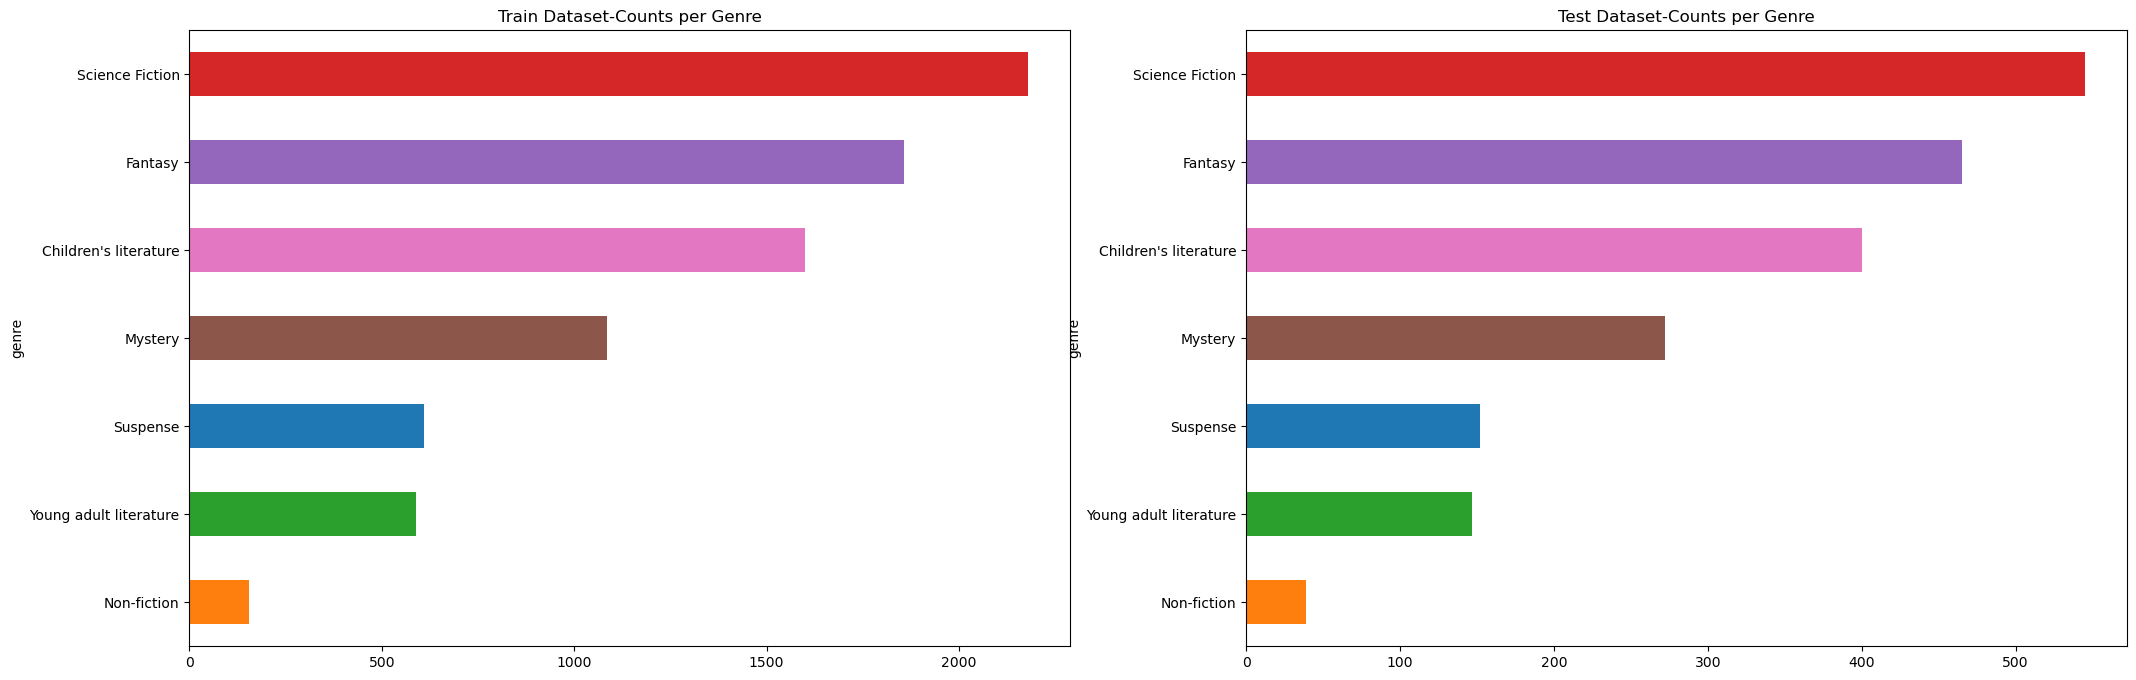

In [29]:
import matplotlib.pyplot as plt 
train, test = train_test_split(book_df, random_state=42, test_size=0.2, shuffle=True, stratify=book_df['genre'])

train_x = train.Tokenized_Summary
train_y = train.genre
test_x = test.Tokenized_Summary.to_numpy()
test_y = test.genre.to_numpy()
test_titles = test['title'].to_numpy()

print("Training dataset = {}".format(len(train_x)))
print("Testing dataset = {}".format(len(test_x)))

colors=['tab:orange', 'tab:green', 'tab:blue', 'tab:brown', 'tab:pink', 'tab:purple','tab:red', 'tab:gray', 'tab:olive']
plt.figure(figsize=(25,8))
plt.subplot(1,2,1).set_title("Train Dataset-Counts per Genre")
train.groupby('genre').size().sort_values(ascending=True).plot(kind='barh', color=colors,ax=plt.gca())
plt.subplot(1,2,2).set_title("Test Dataset-Counts per Genre")
test.groupby('genre').size().sort_values(ascending=True).plot(kind='barh', color=colors,ax=plt.gca())
plt.show()

Training dataset = 9086
Testing dataset = 1010


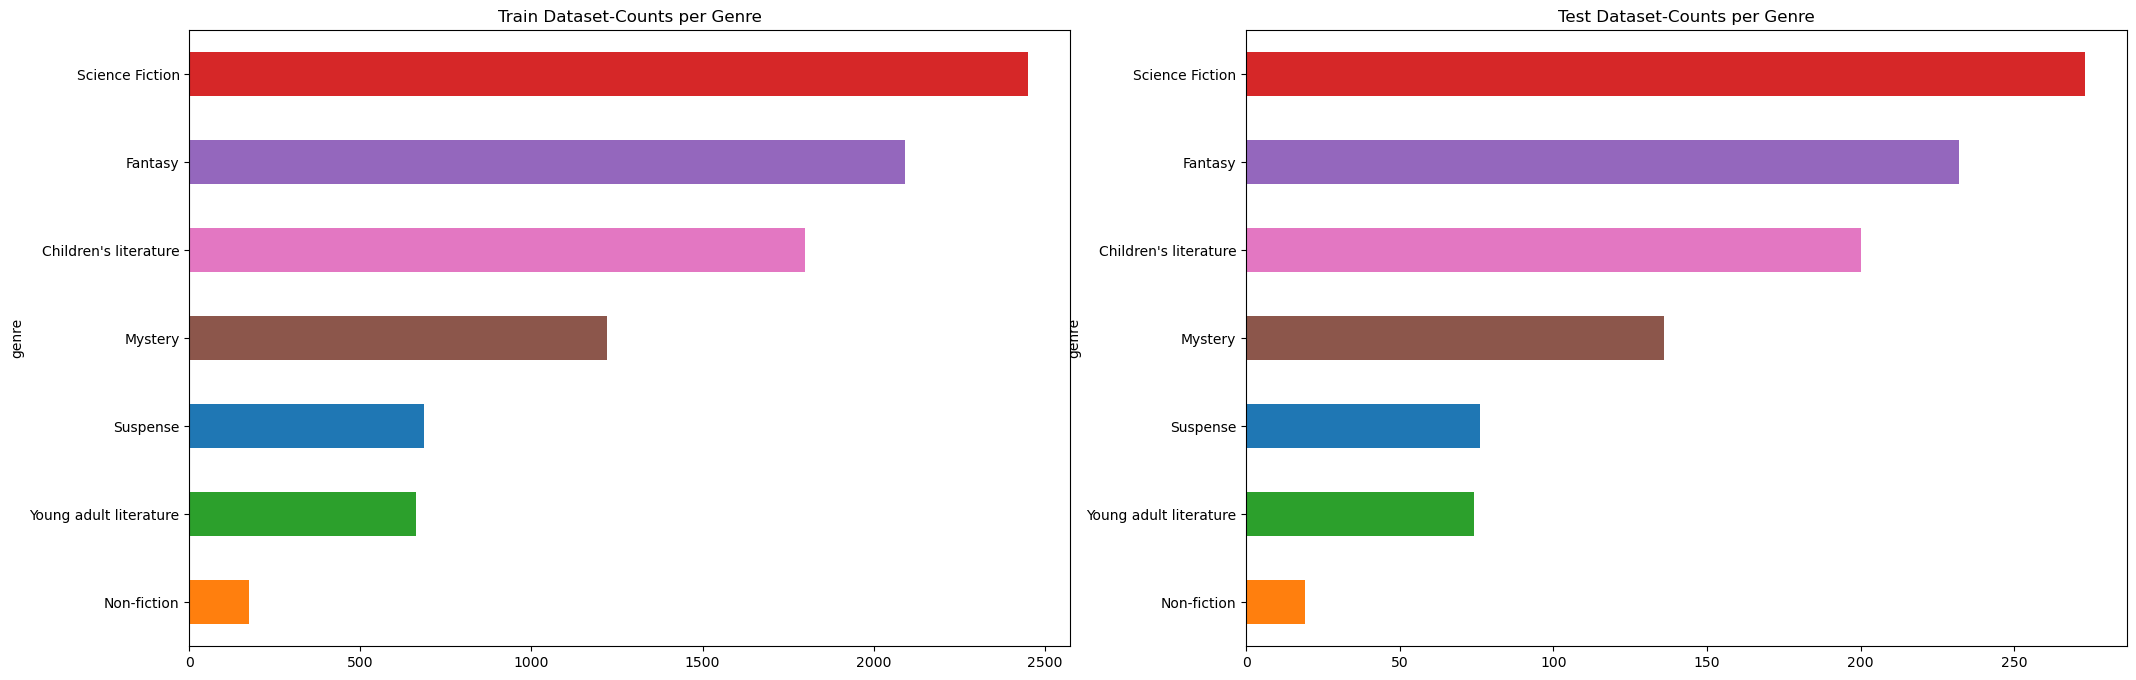

C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_clas

Testing Accuracy: 0.4089108910891089
                        precision    recall  f1-score   support

 Children's literature       0.38      0.41      0.39       200
               Fantasy       0.38      0.39      0.39       232
               Mystery       0.29      0.32      0.30       136
           Non-fiction       0.83      0.53      0.65        19
       Science Fiction       0.58      0.63      0.60       273
              Suspense       0.00      0.00      0.00        76
Young adult literature       0.31      0.23      0.26        74

              accuracy                           0.41      1010
             macro avg       0.40      0.36      0.37      1010
          weighted avg       0.40      0.41      0.40      1010

Model saved as: ./SVC_model.sav


In [30]:
#attempt 5

# Splitting the data
train, test = train_test_split(book_df, random_state=42, test_size=0.1, shuffle=True, stratify=book_df['genre'])

train_x = train.Tokenized_Summary.apply(lambda x: ' '.join(x))  # Convert tokenized words back to raw text
train_y = train.genre
test_x = test.Tokenized_Summary.apply(lambda x: ' '.join(x)).to_numpy()  # Convert tokenized words back to raw text
test_y = test.genre.to_numpy()
test_titles = test['title'].to_numpy()

print("Training dataset = {}".format(len(train_x)))
print("Testing dataset = {}".format(len(test_x)))

# Plotting dataset counts per genre
colors=['tab:orange', 'tab:green', 'tab:blue', 'tab:brown', 'tab:pink', 'tab:purple','tab:red', 'tab:gray', 'tab:olive']
plt.figure(figsize=(25,8))
plt.subplot(1,2,1).set_title("Train Dataset-Counts per Genre")
train.groupby('genre').size().sort_values(ascending=True).plot(kind='barh', color=colors,ax=plt.gca())
plt.subplot(1,2,2).set_title("Test Dataset-Counts per Genre")
test.groupby('genre').size().sort_values(ascending=True).plot(kind='barh', color=colors,ax=plt.gca())
plt.show()

# Creating and training the model
SVC_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
    ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
])
SVC_pipeline.fit(train_x, train_y)

# Evaluating the model
y_pred = SVC_pipeline.predict(test_x)
accuracy = accuracy_score(test_y, y_pred)
print("Testing Accuracy:", accuracy)
print(classification_report(test_y, y_pred))

# Saving the trained model
filename = "./SVC_model.sav"
print("Model saved as:", filename)

In [31]:
#printing accuracy 
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 0.7473035439137135
Testing Accuracy: 0.44554455445544555


In [32]:
#attempt 6 
# Preparing data
book_df["Tokenized_Summary"] = book_df["Tokenized_Summary"].apply(lambda x: x if isinstance(x, list) else [])
X = book_df["Tokenized_Summary"].apply(lambda x: " ".join(x))
y = book_df["genre"]
stop_words = 'english'  # Using the string 'english' for the built-in stop words

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=25)

# Extracting features
vectorizer = TfidfVectorizer(max_features=1000)  

# Selecting SVC model
model = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2))),
    ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
])

# Training the model
model.fit(X_train, y_train)

# Evaluating the model
y_pred = model.predict(X_test)

# Calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Printing classification report
print(classification_report(y_test, y_pred))

# Evaluate the model
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)

C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\koali\anaconda3\Lib\site-packages\sklearn\svm\_clas

Accuracy: 0.44554455445544555
                        precision    recall  f1-score   support

 Children's literature       0.39      0.50      0.44       187
               Fantasy       0.40      0.40      0.40       219
               Mystery       0.39      0.35      0.37       141
           Non-fiction       0.92      0.43      0.59        28
       Science Fiction       0.61      0.66      0.63       296
              Suspense       0.02      0.02      0.02        65
Young adult literature       0.38      0.19      0.25        74

              accuracy                           0.45      1010
             macro avg       0.44      0.36      0.38      1010
          weighted avg       0.45      0.45      0.44      1010

Training Accuracy: 0.7473035439137135
Testing Accuracy: 0.44554455445544555
